In [11]:
# 忽略警告訊息
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

# 載入數據
df = pd.read_csv("titanic.csv")
print(df.shape)
df.head(2)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [2]:
# 顯示 dataframe
from IPython.display import display
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

,Sex,Survived
0,female,0.742
1,male,0.189


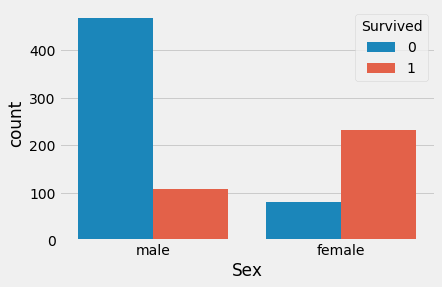

In [3]:
sns.countplot(df['Sex'], hue=df['Survived'])
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3)

性別：大部的男性都罹難(僅剩約 19% 存活)，而女性則大部分都倖存(約 75%)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


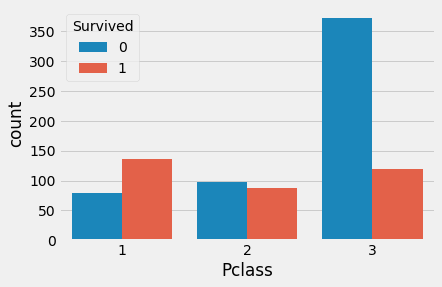

In [4]:
sns.countplot(df['Pclass'], hue=df['Survived'])
df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

艙等：從數據中可發現頭等艙(Pclass=1)的乘客生存機率較高，
可能不論是逃生設備或是沈船訊息都最先傳到頭等艙

In [5]:
# 轉換性別資料：0->女性，1->男性
df['Sex_Code'] = df['Sex'].map({'female':1, 'male':0})
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1


Fare        
Survived      0       1
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

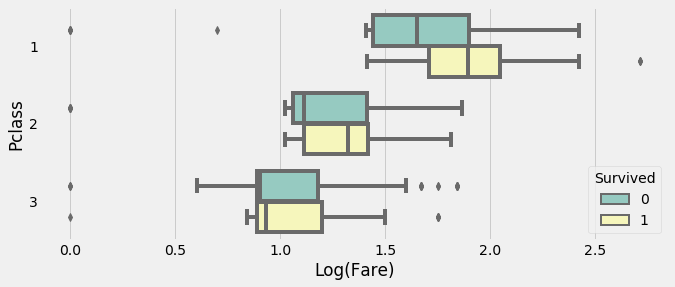

In [6]:
# 由於票價分布非常廣，所以將票價取 log 後再畫圖
fig, ax = plt.subplots(figsize = (10,4))
df['Log(Fare)'] = df['Fare'].map(lambda x:np.log10(x) if x>0 else 0)
sns.boxplot(x='Log(Fare)', y='Pclass', hue='Survived', data=df, orient='h', 
            ax=ax, palette="Set3")
pd.pivot_table(df, values=['Fare'], index=['Pclass'], columns=['Survived'], 
               aggfunc='median').round(3)

票價和艙等都是屬於彰顯乘客社會地位的一個特徵，買票價格較高的乘客，他們的生存機率也較高。

In [7]:
# 登船港口(Embarked)只有遺漏少數，直接補上出現次數最多的 S
df['Embarked'] = df['Embarked'].fillna('S')

# 費用(Fare)也只有遺漏一筆，因此就直接補上平均值
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

Age 遺漏筆數： 177


Sex,female,male,All
Has_Age,,,
0,53,124,177
1,261,453,714
All,314,577,891


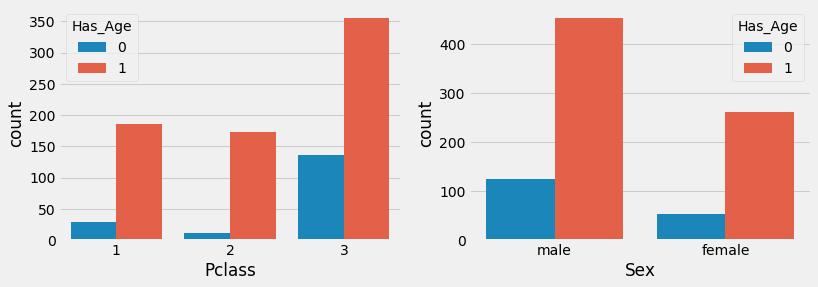

In [8]:
# 年紀(Age)的遺漏值較多，需好好思考如何填補
print('Age 遺漏筆數：', df['Age'].isnull().sum())

# 0->遺漏 Age
df['Has_Age'] = df['Age'].isnull().map(lambda x: 0 if x else 1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
sns.countplot(df['Pclass'], hue=df['Has_Age'], ax=ax1)
sns.countplot(df['Sex'], hue=df['Has_Age'], ax=ax2)
pd.crosstab(df['Has_Age'], df['Sex'], margins=True).round(3)

# sns.countplot(df['Pclass'], hue=df['Has_Age'])

- 左圖：年紀遺漏值大部分在3等艙，如果年紀是個重要特徵，則我們對3等艙的觀察就會失真。
 * 保守的作法是觀察1,2艙等中年紀對存活與否的影響
- 右圖：顯示了遺漏值對性別的分布，其中314位女性有53位缺失年齡(~16.9%)，577位男性有124位缺失年齡(~21.5%)，男性遺漏年紀的比例稍微多一點(~4.6%)。

Title,Dr,Master,Miss,Mr,Mrs
Pclass,,,,,
1,1,0,1,20,8
2,0,0,2,9,0
3,0,4,33,90,9


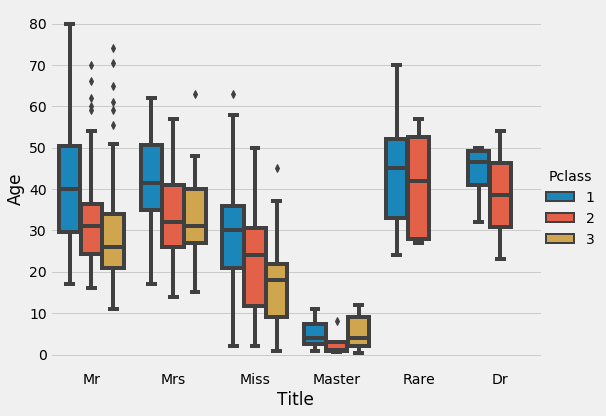

In [9]:
# 填入遺漏值的方式打算使用姓名中同稱謂的平均值來填補
# 取出姓名當中的稱謂
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)

title = df['Title'].value_counts().index
rare = title[5:]
df['Title'] = df['Title'].map(lambda x: 'Rare' if x in rare else x)
df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Mme'], 'Miss')
df['Title'] = df['Title'].replace(['Lady'], 'Mrs')

sns.factorplot(x='Title', y='Age', kind='box', hue='Pclass', data=df, 
               size=6, aspect=1.3)

missing_mask = (df['Has_Age'] == 0)
pd.crosstab(df[missing_mask]['Pclass'], df[missing_mask]['Title'])

In [10]:
df['Title'] = df['Title'].map({"Mr":0, "Rare":1, "Master":2, "Miss":3, "Mrs":4, "Dr":5})
impute = df.groupby('Title')['Age'].mean().values
df['Imp_Age'] = df['Age']

for i in range(0, 6):
    df.loc[(df.Imp_Age.isnull()) & (df.Title == i), 'Imp_Age'] = impute[i]
df['Imp_Age'] = df['Imp_Age'].astype('int')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code,Log(Fare),Has_Age,Title,Imp_Age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0.860338,1,0,22
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1.852988,1,4,38
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0.898999,1,3,26
